In [2]:
%%capture
!pip install linearmodels
!pip install prettytable

Creating interaction terms...
Created interaction terms: roa_maturity, roa_decline
Running regressions with year fixed effects...

✅ Saved TXT to regression_results.txt
✅ Saved CSV to regression_results.csv
Saving PNG image...
✅ Saved PNG to regression_results.png

Analysis complete!


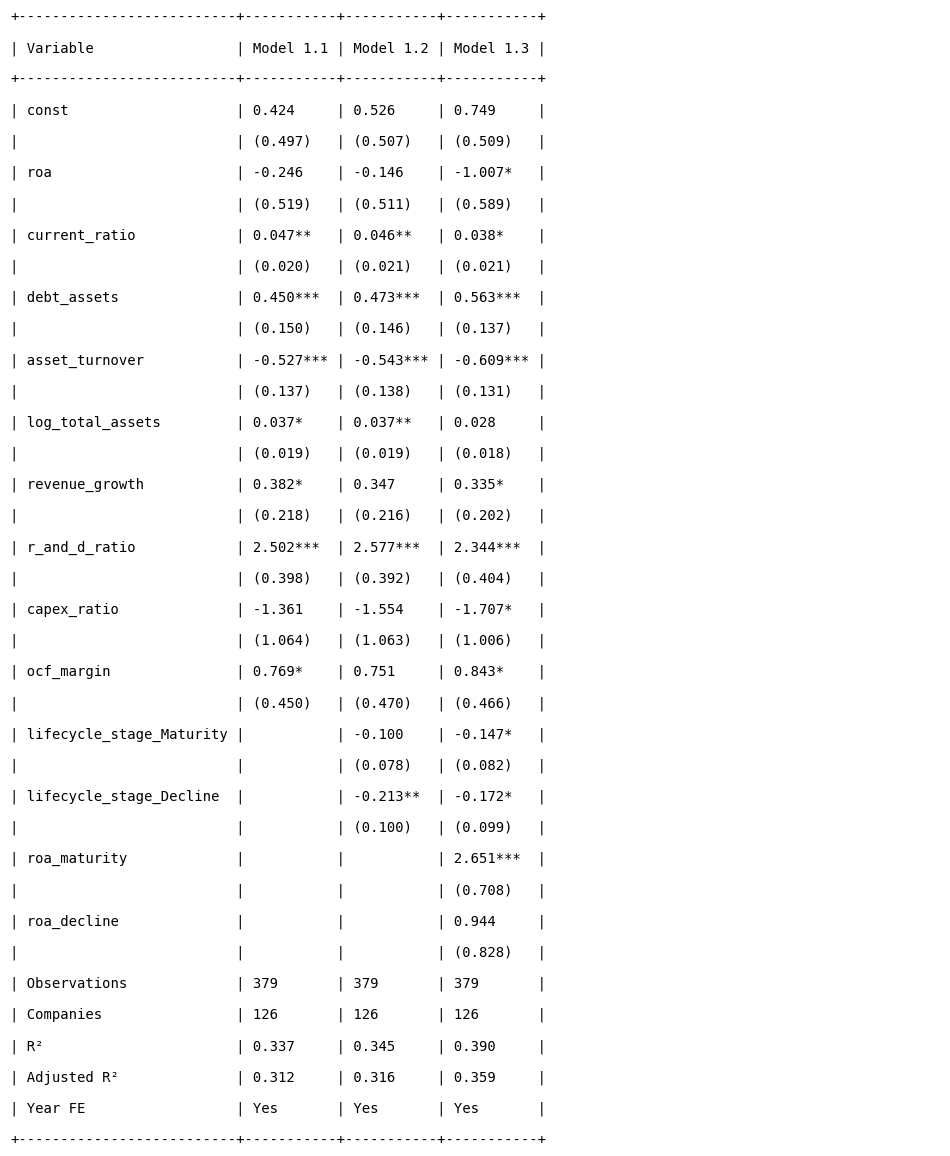

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import os
import csv

# ------------------------------------------------------------------------------
# CONFIGURATION
# ------------------------------------------------------------------------------
INPUT_PATH = "regression_dataset.csv"
OUTPUT_FILENAME = "regression_results"

# Load dataset
df = pd.read_csv(INPUT_PATH)
df = df.set_index(['ticker', 'year'])

# ------------------------------------------------------------------------------
# DEFINE VARIABLES
# ------------------------------------------------------------------------------
dependent = 'log_ev_sales'

controls = [
    'roa',
    'current_ratio',
    'debt_assets',
    'asset_turnover',
    'log_total_assets',
    'revenue_growth',
    'r_and_d_ratio',
    'capex_ratio',
    'ocf_margin'
]

life_stage = [

    'lifecycle_stage_Maturity',
     'lifecycle_stage_Decline'
     ]

# Create interaction terms
print("Creating interaction terms...")
interactions = []
for stage in life_stage:
    interaction_name = f"roa_{stage.split('_')[-1].lower()}"
    df[interaction_name] = df['roa'] * df[stage]
    interactions.append(interaction_name)

print(f"Created interaction terms: {', '.join(interactions)}")

# ------------------------------------------------------------------------------
# DEFINE REGRESSION MODELS
# ------------------------------------------------------------------------------
y = df[dependent]

X1_vars = controls.copy()
X1 = df[X1_vars]
X1 = sm.add_constant(X1)

X2_vars = controls + life_stage
X2 = df[X2_vars]
X2 = sm.add_constant(X2)

X3_vars = controls + life_stage + interactions
X3 = df[X3_vars]
X3 = sm.add_constant(X3)

print("Running regressions with year fixed effects...")
model1 = PanelOLS(y, X1, time_effects=True).fit(cov_type='robust')
model2 = PanelOLS(y, X2, time_effects=True).fit(cov_type='robust')
model3 = PanelOLS(y, X3, time_effects=True).fit(cov_type='robust')

# ------------------------------------------------------------------------------
# TABLE SETUP
# ------------------------------------------------------------------------------
def calculate_adj_rsquared(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

def add_stars(pval):
    if pval < 0.01:
        return '***'
    elif pval < 0.05:
        return '**'
    elif pval < 0.10:
        return '*'
    else:
        return ''

ordered_params = ['const'] + controls + life_stage + interactions
n_companies = df.index.get_level_values(0).nunique()
n_years = df.index.get_level_values(1).nunique() - 1

# ------------------------------------------------------------------------------
# GENERATE TABLE
# ------------------------------------------------------------------------------
table = PrettyTable()
table.field_names = ["Variable", "Model 1.1", "Model 1.2", "Model 1.3"]
table.align = "l"

for param in ordered_params:
    row = [param]
    for res in [model1, model2, model3]:
        if param in res.params.index:
            coef = res.params[param]
            se = res.std_errors[param]
            stars = add_stars(res.pvalues[param])
            row.append(f"{coef:.3f}{stars}\n({se:.3f})")
        else:
            row.append("")
    table.add_row(row)

adj_r2_1 = calculate_adj_rsquared(model1.rsquared, model1.nobs, len(X1_vars) + 1 + n_years)
adj_r2_2 = calculate_adj_rsquared(model2.rsquared, model2.nobs, len(X2_vars) + 1 + n_years)
adj_r2_3 = calculate_adj_rsquared(model3.rsquared, model3.nobs, len(X3_vars) + 1 + n_years)

table.add_row(["Observations", f"{int(model1.nobs)}", f"{int(model2.nobs)}", f"{int(model3.nobs)}"])
table.add_row(["Companies", f"{n_companies}", f"{n_companies}", f"{n_companies}"])
table.add_row(["R²", f"{model1.rsquared:.3f}", f"{model2.rsquared:.3f}", f"{model3.rsquared:.3f}"])
table.add_row(["Adjusted R²", f"{adj_r2_1:.3f}", f"{adj_r2_2:.3f}", f"{adj_r2_3:.3f}"])
table.add_row(["Year FE", "Yes", "Yes", "Yes"])

# ------------------------------------------------------------------------------
# SAVE AS TXT AND CSV
# ------------------------------------------------------------------------------
csv_path = f"{OUTPUT_FILENAME}.csv"
txt_path = f"{OUTPUT_FILENAME}.txt"

with open(csv_path, "w", newline='') as f_csv:
    writer = csv.writer(f_csv)
    writer.writerow(table.field_names)
    writer.writerows(table._rows)

with open(txt_path, "w") as f_txt:
    f_txt.write("Regression Results:\n")
    f_txt.write(table.get_string())
    f_txt.write("\n\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")

print(f"\n✅ Saved TXT to {txt_path}")
print(f"✅ Saved CSV to {csv_path}")

# ------------------------------------------------------------------------------
# SAVE AS PNG
# ------------------------------------------------------------------------------
print("Saving PNG image...")
fig, ax = plt.subplots(figsize=(12, 0.5 + 0.4 * len(table._rows)))
ax.axis('off')
table_text = table.get_string()
lines = table_text.splitlines()
for i, line in enumerate(lines):
    ax.text(0, 1 - i * 0.05, line, family='monospace', fontsize=10, va='top')

plt.savefig(f"{OUTPUT_FILENAME}.png", bbox_inches='tight', dpi=300)
print(f"✅ Saved PNG to {OUTPUT_FILENAME}.png")

print("\nAnalysis complete!")


In [ ]:
import pandas as pd

# -------------------------------------------------------------------
# FUNCTION TO CALCULATE ADJUSTED R-SQUARED
# -------------------------------------------------------------------
def calculate_adj_rsquared(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# -------------------------------------------------------------------
# FUNCTION TO SAVE MODEL RESULTS TO CSV
# -------------------------------------------------------------------
def save_model_to_csv(model, model_name, X_vars, n_years):
    df_output = pd.DataFrame(index=model.params.index)
    df_output["Coefficient"] = model.params.round(3)
    df_output["Std. Error"] = model.std_errors.round(3)
    df_output["P-Value"] = model.pvalues.round(3)

    adj_r2 = calculate_adj_rsquared(model.rsquared, model.nobs, len(X_vars) + 1 + n_years)
    summary_rows = pd.DataFrame({
        "Coefficient": [model.nobs, round(model.rsquared, 3), round(adj_r2, 3), "Yes"],
        "Std. Error": ["", "", "", ""],
        "P-Value": ["", "", "", ""]
    }, index=["Observations", "R²", "Adjusted R²", "Year FE"])

    df_output = pd.concat([df_output, summary_rows])

    file_path = f"{model_name}.csv"
    df_output.to_csv(file_path)
    print(f"✅ Saved clean model results to {file_path}")

# -------------------------------------------------------------------
# SAVE INDIVIDUAL MODEL RESULTS
# -------------------------------------------------------------------
save_model_to_csv(model1, f"{OUTPUT_FILENAME}_model1", X1_vars, n_years)
save_model_to_csv(model2, f"{OUTPUT_FILENAME}_model2", X2_vars, n_years)
save_model_to_csv(model3, f"{OUTPUT_FILENAME}_model3", X3_vars, n_years)

✅ Saved clean model results to regression_results_model1.csv
✅ Saved clean model results to regression_results_model2.csv
✅ Saved clean model results to regression_results_model3.csv


Creating interaction terms...
Created interaction terms: roa_maturity, current_ratio_maturity, debt_assets_maturity, asset_turnover_maturity, roa_decline, current_ratio_decline, debt_assets_decline, asset_turnover_decline
Running regressions with year fixed effects...

✅ Saved TXT to interactions_regression_results.txt
✅ Saved CSV to interactions_regression_results.csv
Saving PNG image...
✅ Saved PNG to interactions_regression_results.png

Analysis complete!


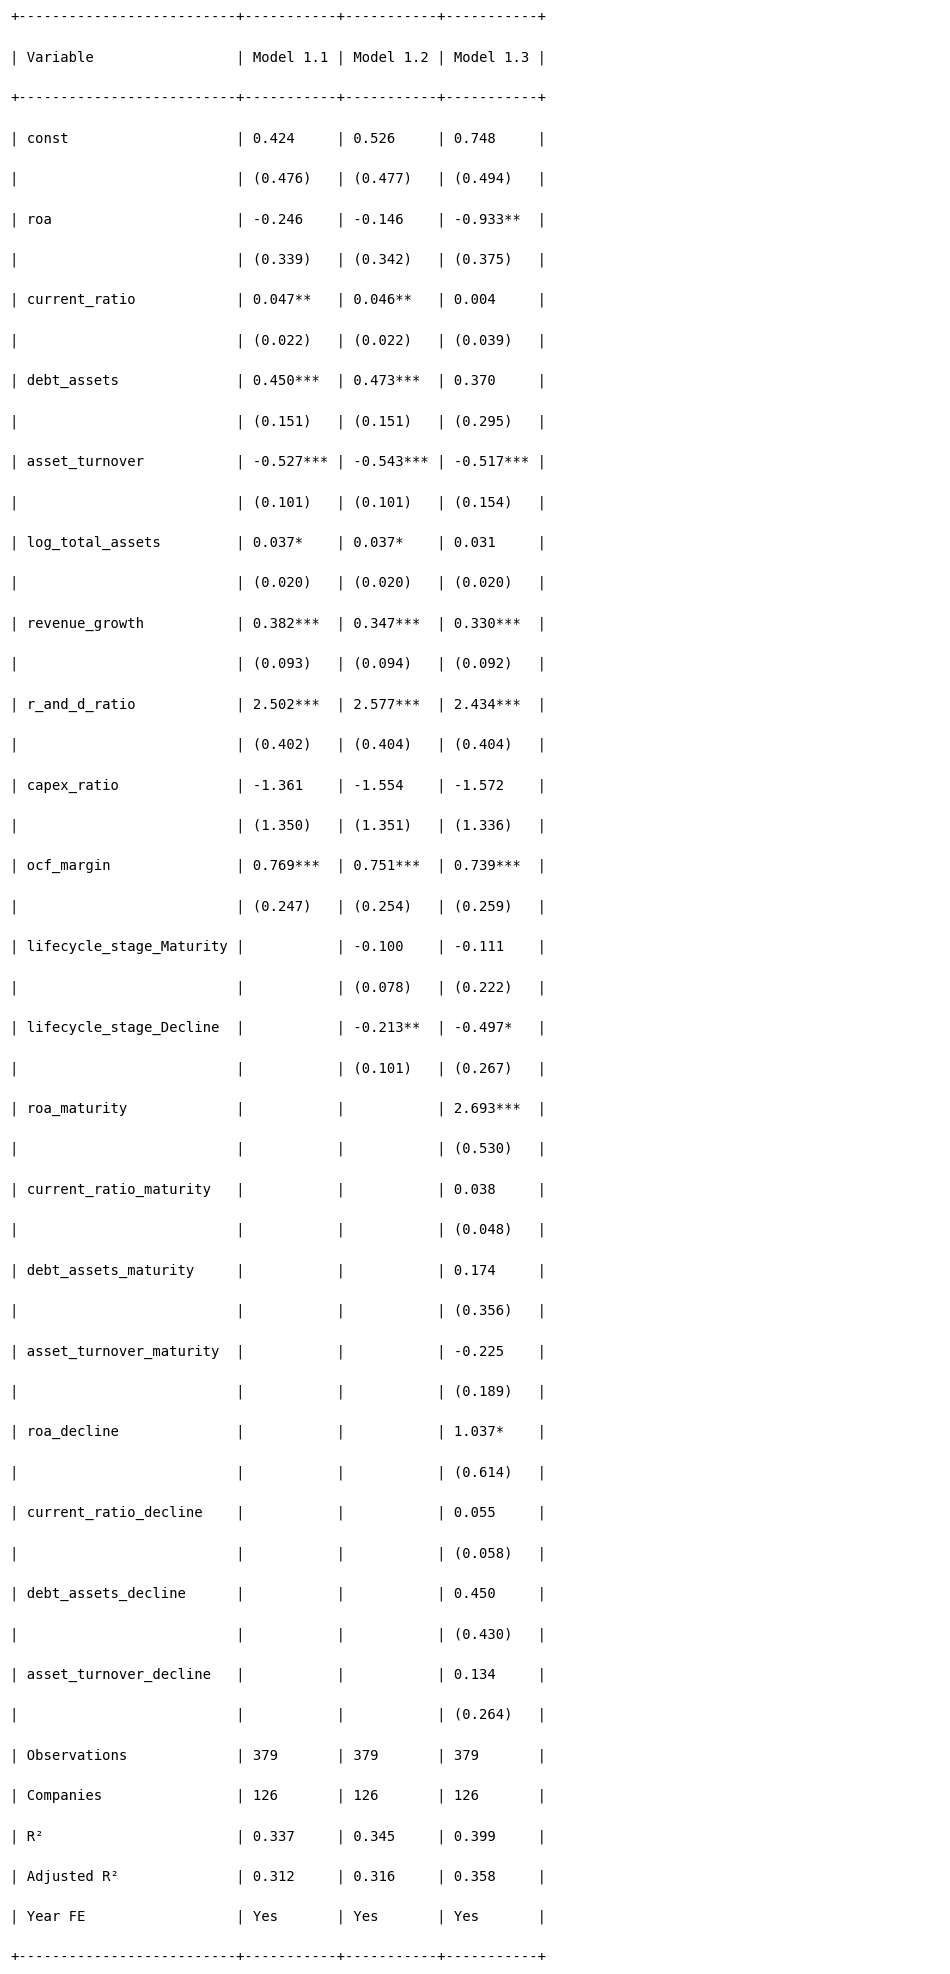

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import os
import csv

# -------------------------------------------------------------------
# CONFIGURATION
# -------------------------------------------------------------------
INPUT_PATH = "regression_dataset.csv"
OUTPUT_FILENAME = "interactions_regression_results"

df = pd.read_csv(INPUT_PATH)
df = df.set_index(['ticker', 'year'])

# -------------------------------------------------------------------
# DEFINE VARIABLES
# -------------------------------------------------------------------
dependent = 'log_ev_sales'

controls = [
    'roa',
    'current_ratio',
    'debt_assets',
    'asset_turnover',
    'log_total_assets',
    'revenue_growth',
    'r_and_d_ratio',
    'capex_ratio',
    'ocf_margin'
]

life_stage = [
    'lifecycle_stage_Maturity',
    'lifecycle_stage_Decline'
]

# -------------------------------------------------------------------
# CREATE INTERACTION TERMS
# -------------------------------------------------------------------
print("Creating interaction terms...")
interactions = []
for stage in life_stage:
    interaction_name_roa = f"roa_{stage.split('_')[-1].lower()}"
    df[interaction_name_roa] = df['roa'] * df[stage]
    interactions.append(interaction_name_roa)

    interaction_name_current_ratio = f"current_ratio_{stage.split('_')[-1].lower()}"
    df[interaction_name_current_ratio] = df['current_ratio'] * df[stage]
    interactions.append(interaction_name_current_ratio)

    interaction_name_debt_assets = f"debt_assets_{stage.split('_')[-1].lower()}"
    df[interaction_name_debt_assets] = df['debt_assets'] * df[stage]
    interactions.append(interaction_name_debt_assets)

    interaction_name_asset_turnover = f"asset_turnover_{stage.split('_')[-1].lower()}"
    df[interaction_name_asset_turnover] = df['asset_turnover'] * df[stage]
    interactions.append(interaction_name_asset_turnover)

print(f"Created interaction terms: {', '.join(interactions)}")

# -------------------------------------------------------------------
# DEFINE REGRESSION MODELS
# -------------------------------------------------------------------
y = df[dependent]

X1_vars = controls.copy()
X1 = df[X1_vars]
X1 = sm.add_constant(X1)

X2_vars = controls + life_stage
X2 = df[X2_vars]
X2 = sm.add_constant(X2)

X3_vars = controls + life_stage + interactions
X3 = df[X3_vars]
X3 = sm.add_constant(X3)

print("Running regressions with year fixed effects...")
model1 = PanelOLS(y, X1, time_effects=True).fit()
model2 = PanelOLS(y, X2, time_effects=True).fit()
model3 = PanelOLS(y, X3, time_effects=True).fit()

# -------------------------------------------------------------------
# TABLE SETUP
# -------------------------------------------------------------------
def calculate_adj_rsquared(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

def add_stars(pval):
    if pval < 0.01:
        return '***'
    elif pval < 0.05:
        return '**'
    elif pval < 0.10:
        return '*'
    else:
        return ''

ordered_params = ['const'] + controls + life_stage + interactions
n_companies = df.index.get_level_values(0).nunique()
n_years = df.index.get_level_values(1).nunique() - 1

# -------------------------------------------------------------------
# GENERATE TABLE
# -------------------------------------------------------------------
table = PrettyTable()
table.field_names = ["Variable", "Model 1.1", "Model 1.2", "Model 1.3"]
table.align = "l"

for param in ordered_params:
    row = [param]
    for res in [model1, model2, model3]:
        if param in res.params.index:
            coef = res.params[param]
            se = res.std_errors[param]
            stars = add_stars(res.pvalues[param])
            row.append(f"{coef:.3f}{stars}\n({se:.3f})")
        else:
            row.append("")
    table.add_row(row)

adj_r2_1 = calculate_adj_rsquared(model1.rsquared, model1.nobs, len(X1_vars) + 1 + n_years)
adj_r2_2 = calculate_adj_rsquared(model2.rsquared, model2.nobs, len(X2_vars) + 1 + n_years)
adj_r2_3 = calculate_adj_rsquared(model3.rsquared, model3.nobs, len(X3_vars) + 1 + n_years)

table.add_row(["Observations", f"{int(model1.nobs)}", f"{int(model2.nobs)}", f"{int(model3.nobs)}"])
table.add_row(["Companies", f"{n_companies}", f"{n_companies}", f"{n_companies}"])
table.add_row(["R²", f"{model1.rsquared:.3f}", f"{model2.rsquared:.3f}", f"{model3.rsquared:.3f}"])
table.add_row(["Adjusted R²", f"{adj_r2_1:.3f}", f"{adj_r2_2:.3f}", f"{adj_r2_3:.3f}"])
table.add_row(["Year FE", "Yes", "Yes", "Yes"])

# -------------------------------------------------------------------
# SAVE AS TXT AND CSV
# -------------------------------------------------------------------
csv_path = f"{OUTPUT_FILENAME}.csv"
txt_path = f"{OUTPUT_FILENAME}.txt"

with open(csv_path, "w", newline='') as f_csv:
    writer = csv.writer(f_csv)
    writer.writerow(table.field_names)
    writer.writerows(table._rows)

with open(txt_path, "w") as f_txt:
    f_txt.write("Regression Results:\n")
    f_txt.write(table.get_string())
    f_txt.write("\n\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")

print(f"\n✅ Saved TXT to {txt_path}")
print(f"✅ Saved CSV to {csv_path}")

# -------------------------------------------------------------------
# SAVE AS PNG
# -------------------------------------------------------------------
print("Saving PNG image...")
fig, ax = plt.subplots(figsize=(12, 0.5 + 0.4 * len(table._rows)))
ax.axis('off')
table_text = table.get_string()
lines = table_text.splitlines()
for i, line in enumerate(lines):
    ax.text(0, 1 - i * 0.05, line, family='monospace', fontsize=10, va='top')

plt.savefig(f"{OUTPUT_FILENAME}.png", bbox_inches='tight', dpi=300)
print(f"✅ Saved PNG to {OUTPUT_FILENAME}.png")

print("\nAnalysis complete!")